In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.rcParams.update({"figure.dpi": 300})
import tests_and_models.stats_tests as stats_tests
from matplotlib.patches import Rectangle
sns.set_context('paper')
sns.set_style('whitegrid')

In [2]:
# Run normality test on flowering time data
ft= pd.read_csv('./data/processed.csv', index_col=0, header=None).transpose().astype({'5_FT10':np.float64})['5_FT10'].to_numpy()

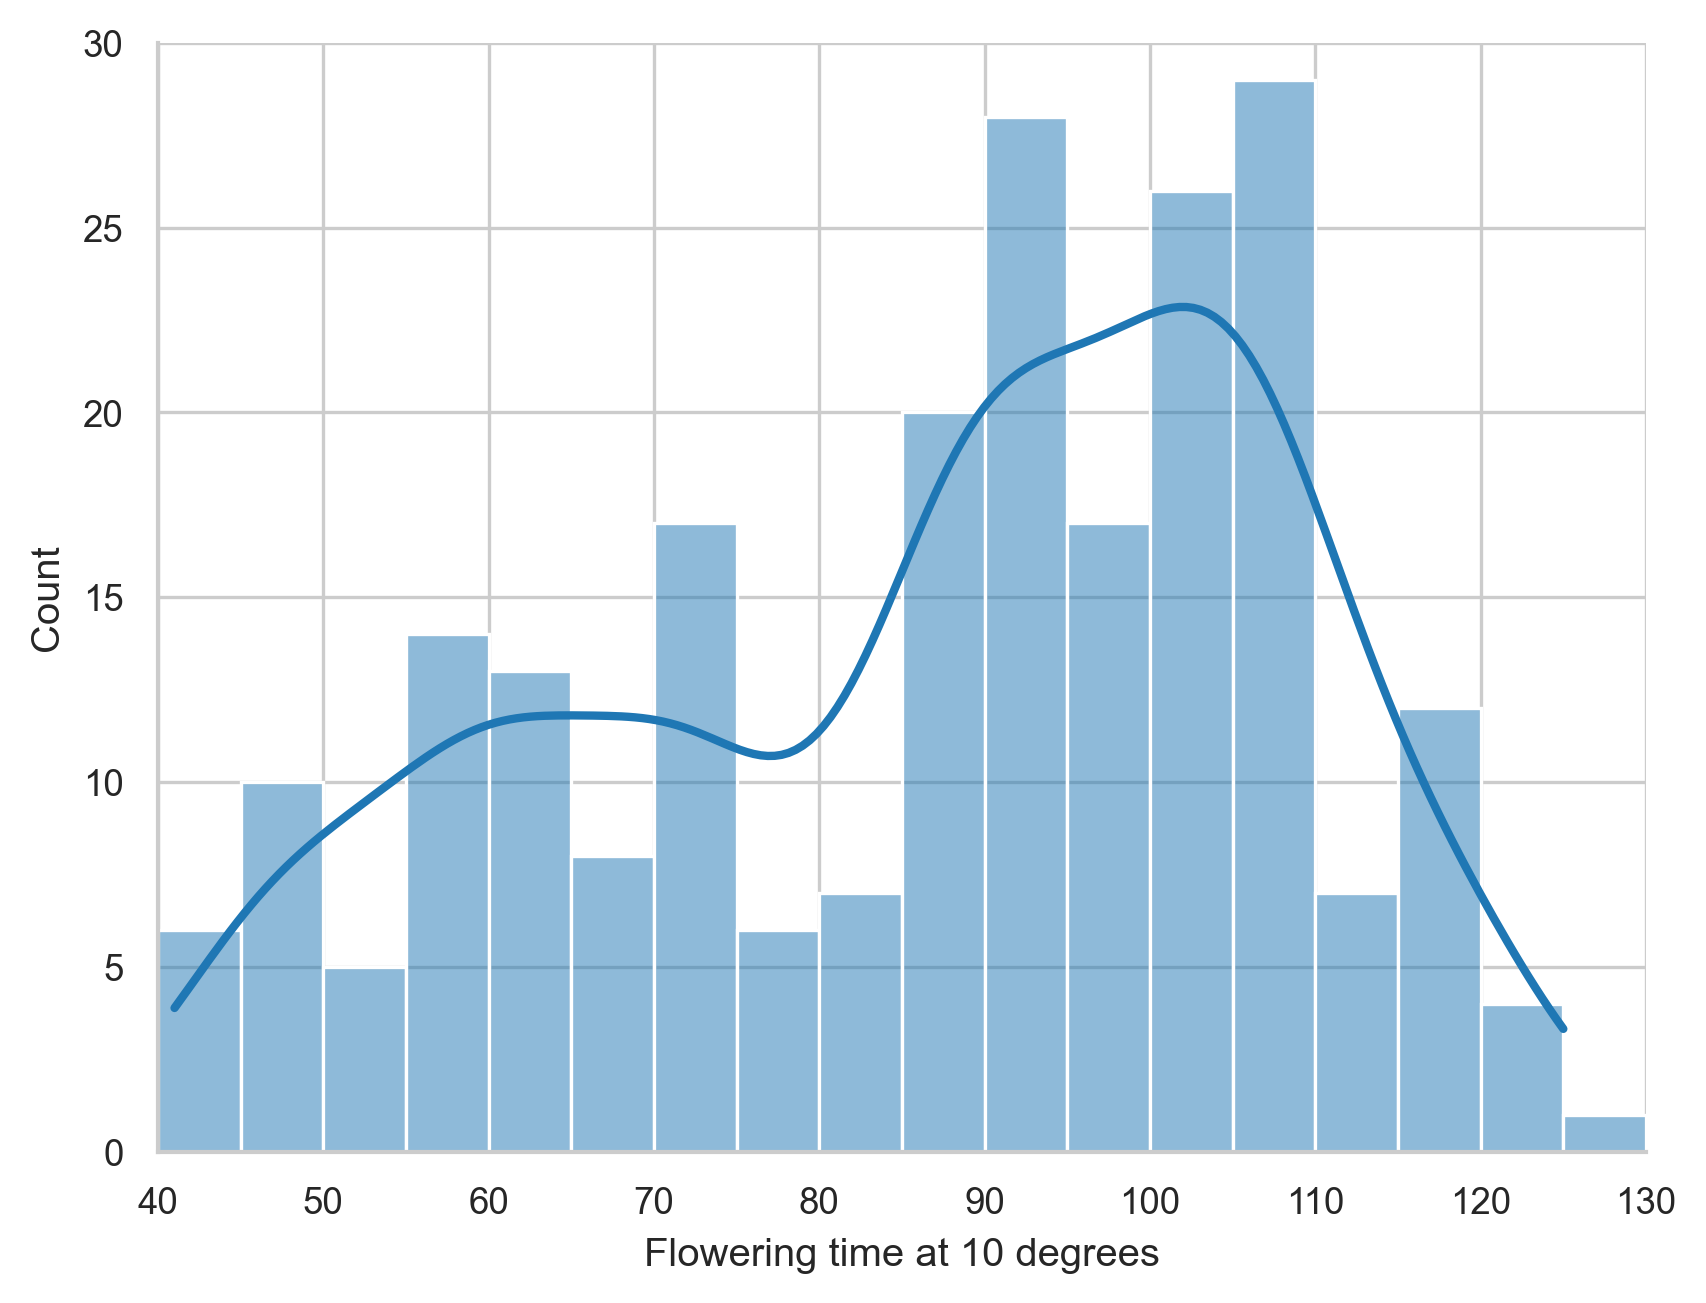

In [3]:
hist_plot = sns.histplot(x=ft, kde=True, binwidth=5, binrange=(40,130), line_kws={'lw':2}, kde_kws={'bw_adjust': .8})
hist_plot.set_xlabel('Flowering time at 10 degrees')
hist_plot.set_ylim(0,30)
hist_plot.set_xlim(40,130)
sns.despine()
plt.show()

In [4]:
stats_tests.normality_test(ft)

KS test p-value: 0.011542904216882125
Shapiro test p-value: 5.966722958354086e-07


In [5]:
test_results = pd.read_csv('./data/stat_test_results.csv')

In [6]:
test_results['negative_log_p'] = -1 * np.log10(test_results['corrected_pval'])

# Adjust positions of SNPs for manhattan plot
test_results['chromosome'] = test_results['location'].map(lambda x: int(str.split(x, ':')[0]))
test_results['position'] = test_results['location'].map(lambda x: int(str.split(x, ':')[1]))
test_results['adjusted_position'] = test_results['position']

start_positions = np.cumsum([test_results.loc[test_results['chromosome'] == i, 'position'].max() for i in range(1,6)])
for i in range(1,5):
    test_results.loc[test_results['chromosome'] == i+1, 'adjusted_position'] = test_results.loc[test_results['chromosome'] == i+1, 'position'] + start_positions[i-1]

In [7]:
# Chreate positions for x axis ticks
chromosomes = sorted(test_results['chromosome'].unique())
medians = [test_results.loc[test_results['chromosome'] == i, 'adjusted_position'].median() for i in chromosomes]

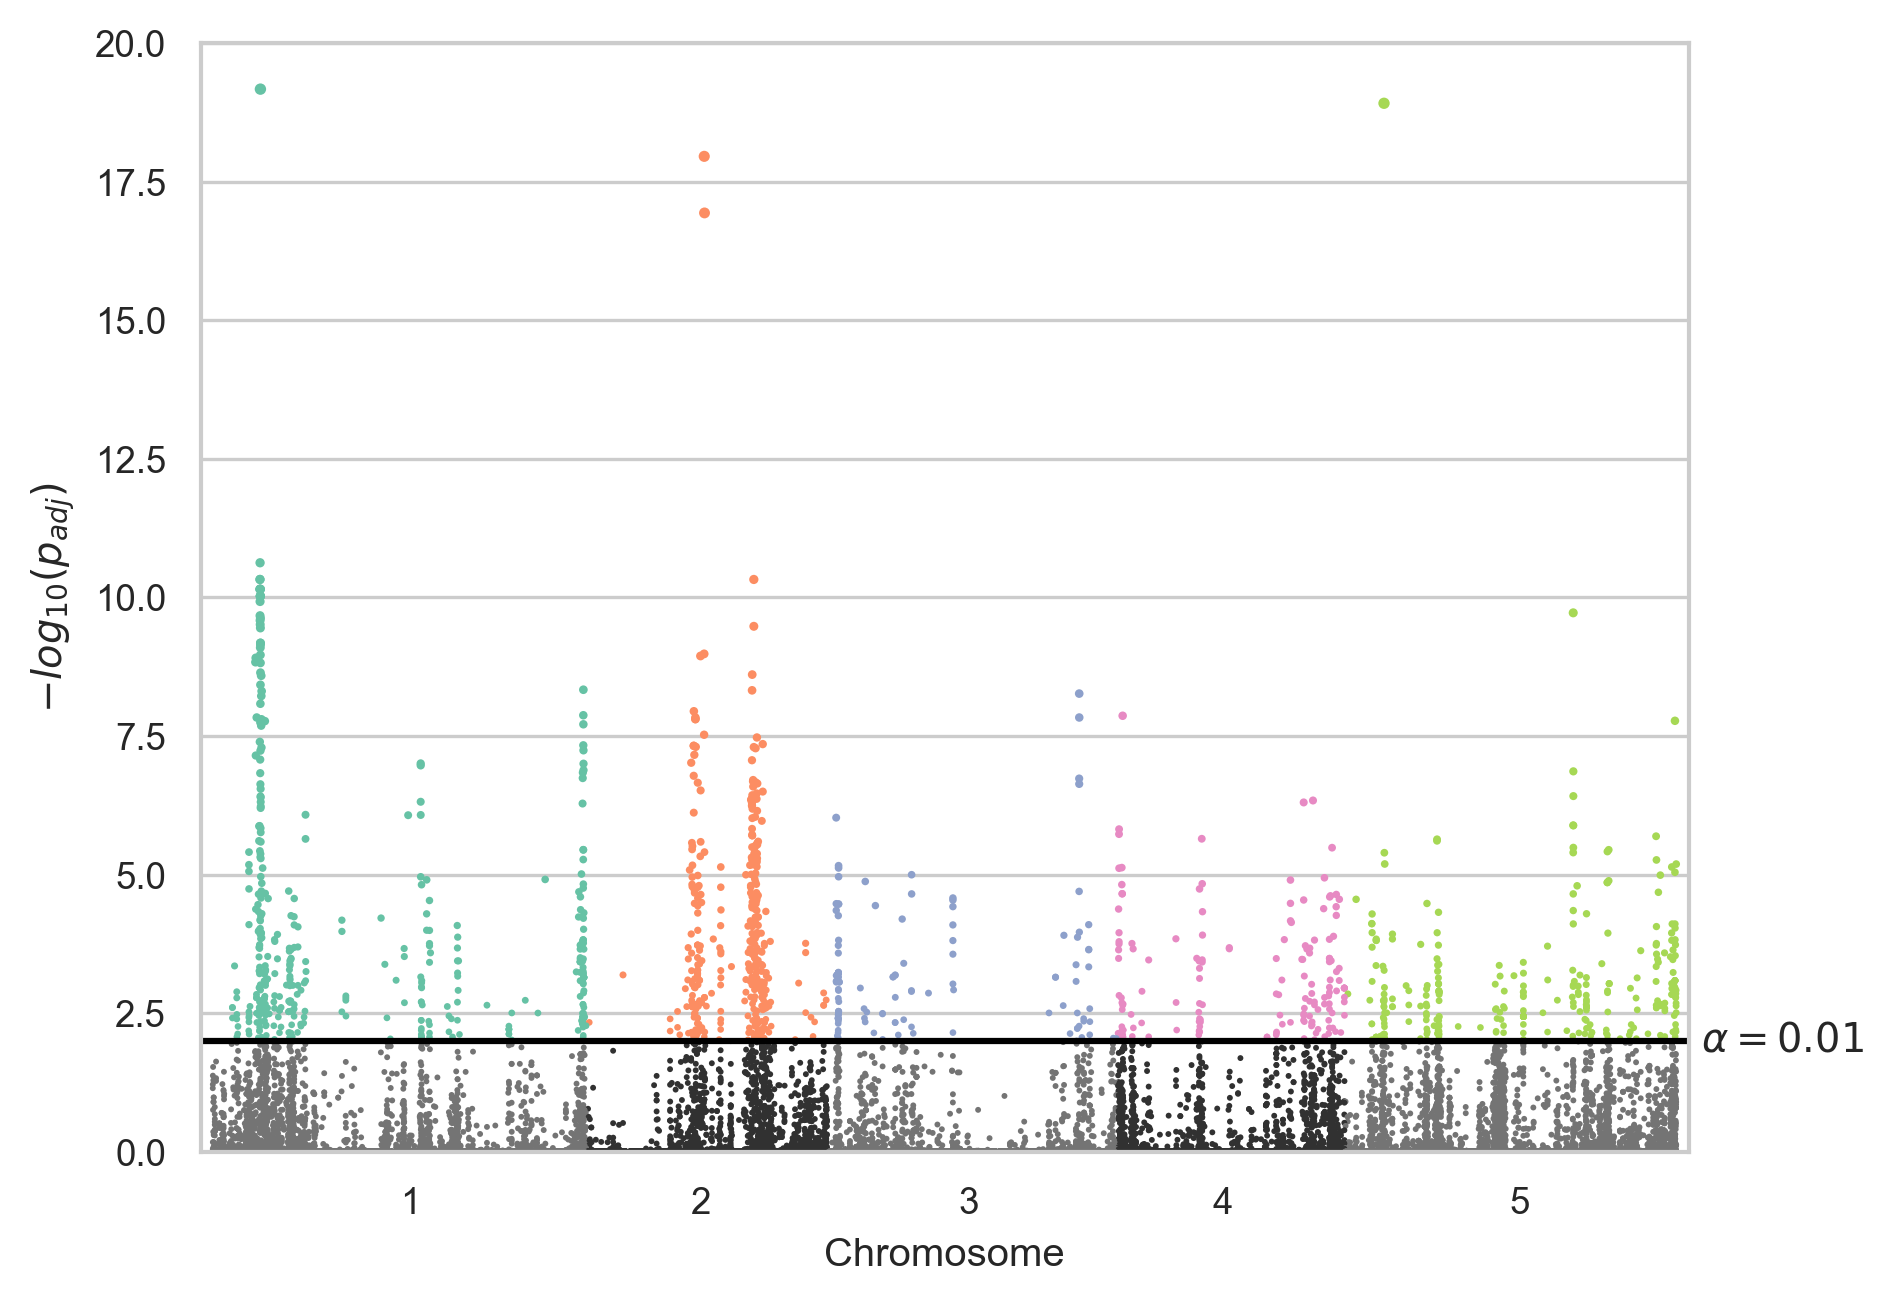

In [8]:
# Make Manhattan plot for Mann-Whitney test results
thresh = -np.log10(0.01)
palette = sns.color_palette('Set2', 5)
gray_pallette = ["#747474", "#313131","#747474", "#313131", "#747474"]
manhattan = sns.scatterplot(data=test_results[test_results['negative_log_p'] > thresh], x='adjusted_position', y='negative_log_p', 
                            hue='chromosome', marker='.', linewidth=0, size='negative_log_p', sizes=(10,30), palette=palette,legend=False)
sns.scatterplot(data=test_results[test_results['negative_log_p'] <= thresh], x='adjusted_position', y='negative_log_p',
                 marker='.', linewidth=0, s=8, hue='chromosome', palette=gray_pallette, ax=manhattan, legend=False)
manhattan.set_xticks(medians, labels=[str(x) for x in chromosomes])
manhattan.set_ylim(0, 20)
manhattan.set_xlabel('Chromosome')
manhattan.set_ylabel(r'$-log_{10}(p_{adj})$')
manhattan.set_xlim(test_results['adjusted_position'].min()-1000000, test_results['adjusted_position'].max() + 1000000)
manhattan.axhline(y=thresh, c='black', lw=1.5)
manhattan.text(x=manhattan.get_xlim()[1]+1000000, y=thresh, s=r'$\alpha=0.01$', ha='left', va='center')
manhattan.grid(axis='x', visible=False)
plt.show()

In [43]:
# Original p-value correction still not conservative enough for permutation test; Using Bonferroni correction instead
m = test_results.shape[0]
test_results['perm_corrected_pval'] = test_results['perm_pval'] * m
test_results.loc[test_results['perm_corrected_pval'] > 1., 'perm_corrected_pval'] = 1

test_results['perm_negative_log_p'] = -1 * np.log10(test_results['perm_corrected_pval'])

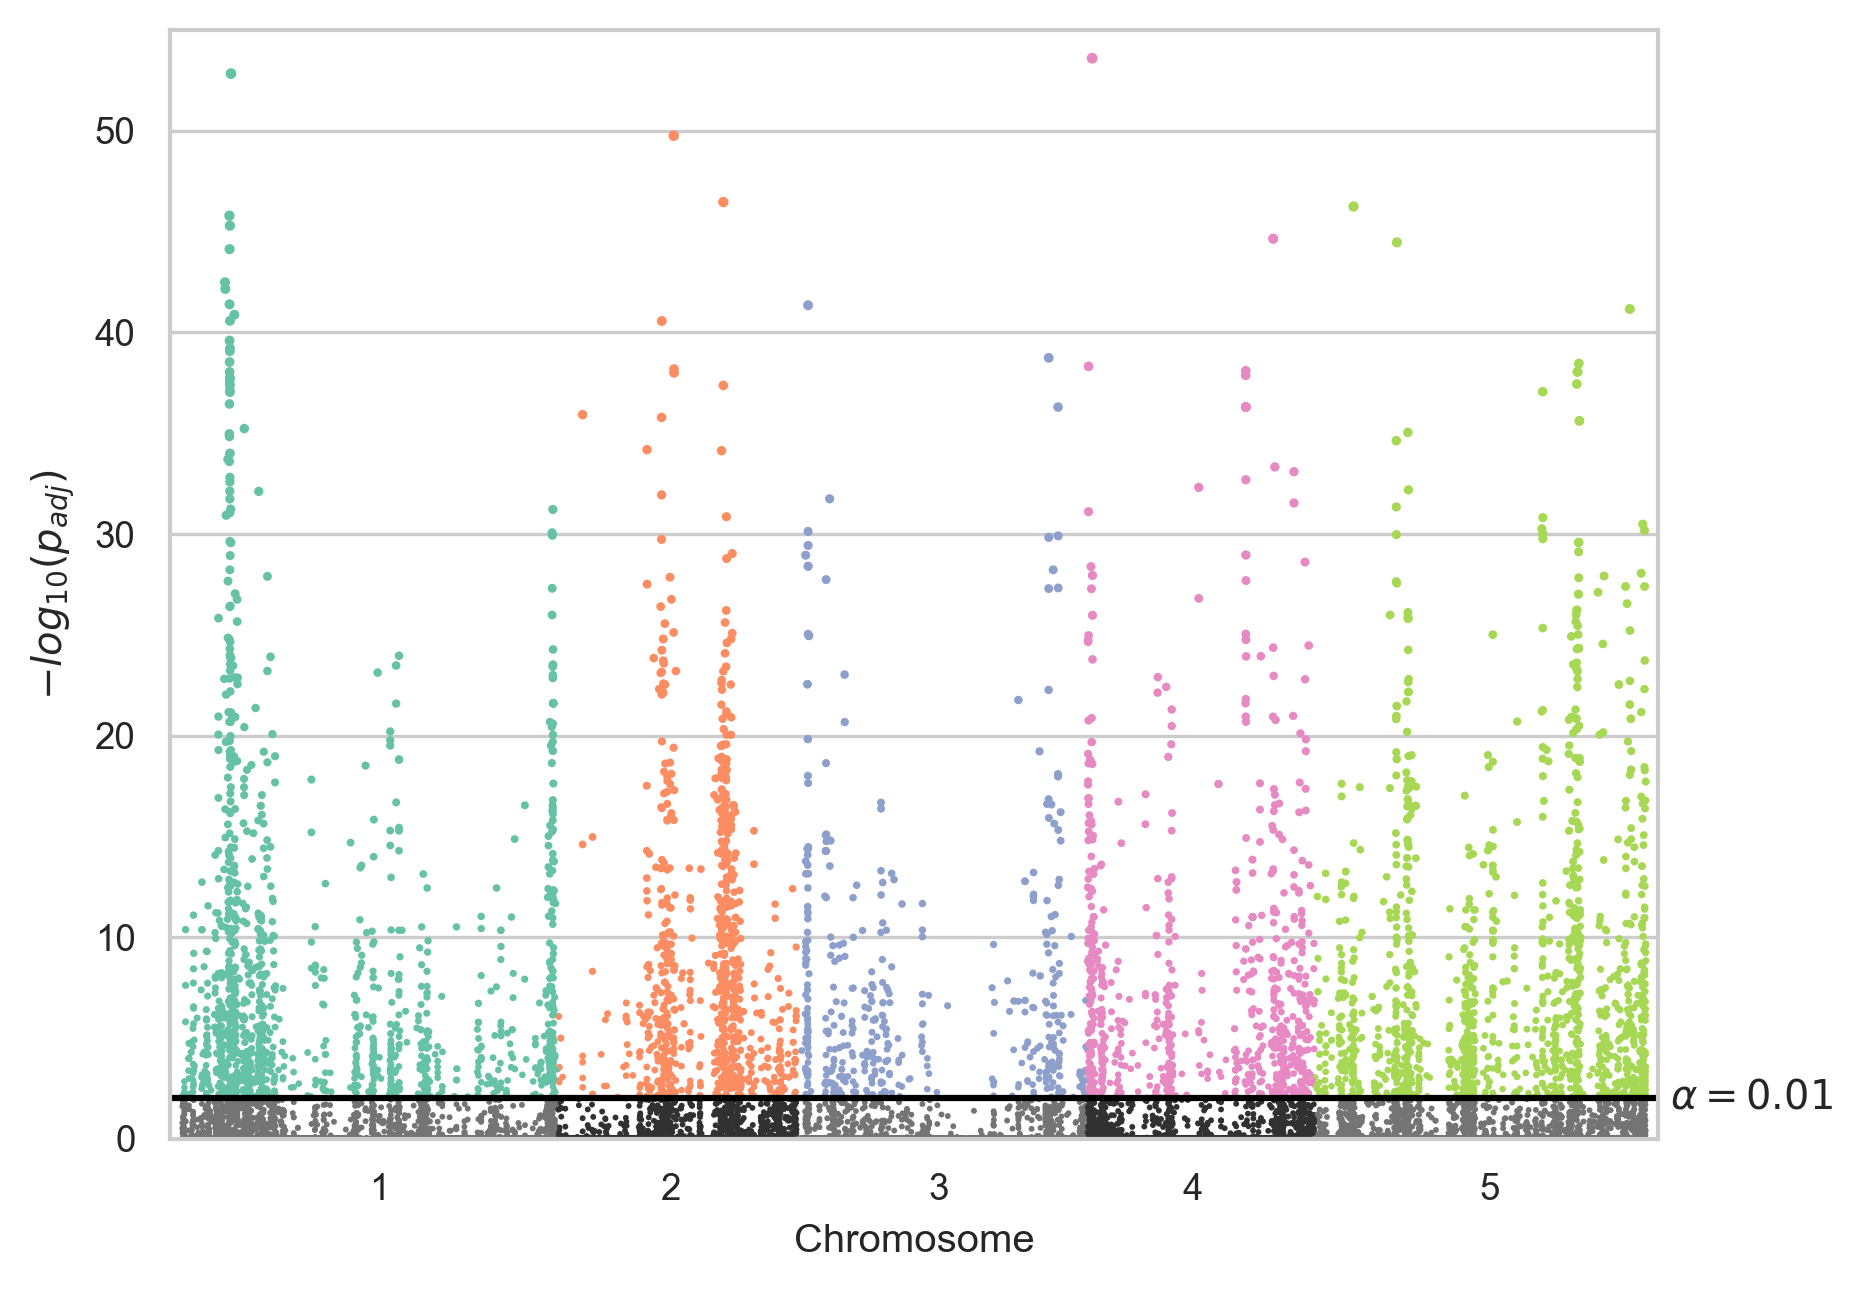

In [10]:
# Make Manhattan plot for permutation test results
perm_manhattan = sns.scatterplot(data=test_results[test_results['perm_negative_log_p'] > -np.log10(0.01)], x='adjusted_position', y='perm_negative_log_p', 
                            hue='chromosome', marker='.', linewidth=0, size='perm_negative_log_p', sizes=(10,30), palette=palette,legend=False)
sns.scatterplot(data=test_results[test_results['perm_negative_log_p'] <= -np.log10(0.01)], x='adjusted_position', y='perm_negative_log_p',
                 marker='.', linewidth=0, s=8, hue='chromosome', palette=gray_pallette, ax=perm_manhattan, legend=False)
perm_manhattan.set_xticks(medians, labels=[str(x) for x in chromosomes])
perm_manhattan.set_xlabel('Chromosome')
perm_manhattan.set_ylabel(r'$-log_{10}(p_{adj})$')
perm_manhattan.set_xlim(test_results['adjusted_position'].min()-1000000, test_results['adjusted_position'].max() + 1000000)
perm_manhattan.axhline(y=thresh, c='black', lw=1.5)
perm_manhattan.grid(axis='x', visible=False)
perm_manhattan.set_ylim(0,55)
perm_manhattan.text(x=perm_manhattan.get_xlim()[1]+1000000, y=thresh, s=r'$\alpha=0.01$', ha='left', va='center')
plt.show()

In [11]:
# Example of edf/permutation test, using one of the significant SNPs from random forest
example_data = pd.read_csv('./data/processed.csv', index_col=0, header=None).transpose().astype({'5_FT10':np.float64})[['5_FT10', '2:8862404']]
[x,y] = [example_data.loc[example_data['2:8862404'] == g, '5_FT10'].to_numpy() for g in example_data.iloc[:,1].unique()]
result = stats_tests.permutation_test(x, y, {}, stats_tests.mean_diff, return_obs=True)
result

{'test_stat': np.float64(22.189096031154193),
 'pvalue': 2.31482344155005e-29,
 'observations': array([4.15537327, 0.09626315, 3.5551247 , ..., 0.01236225, 3.89429116,
        0.4297622 ], shape=(10000,)),
 'edf': <tests_and_models.stats_tests.empirical_distribution at 0x15ce8bb60>}

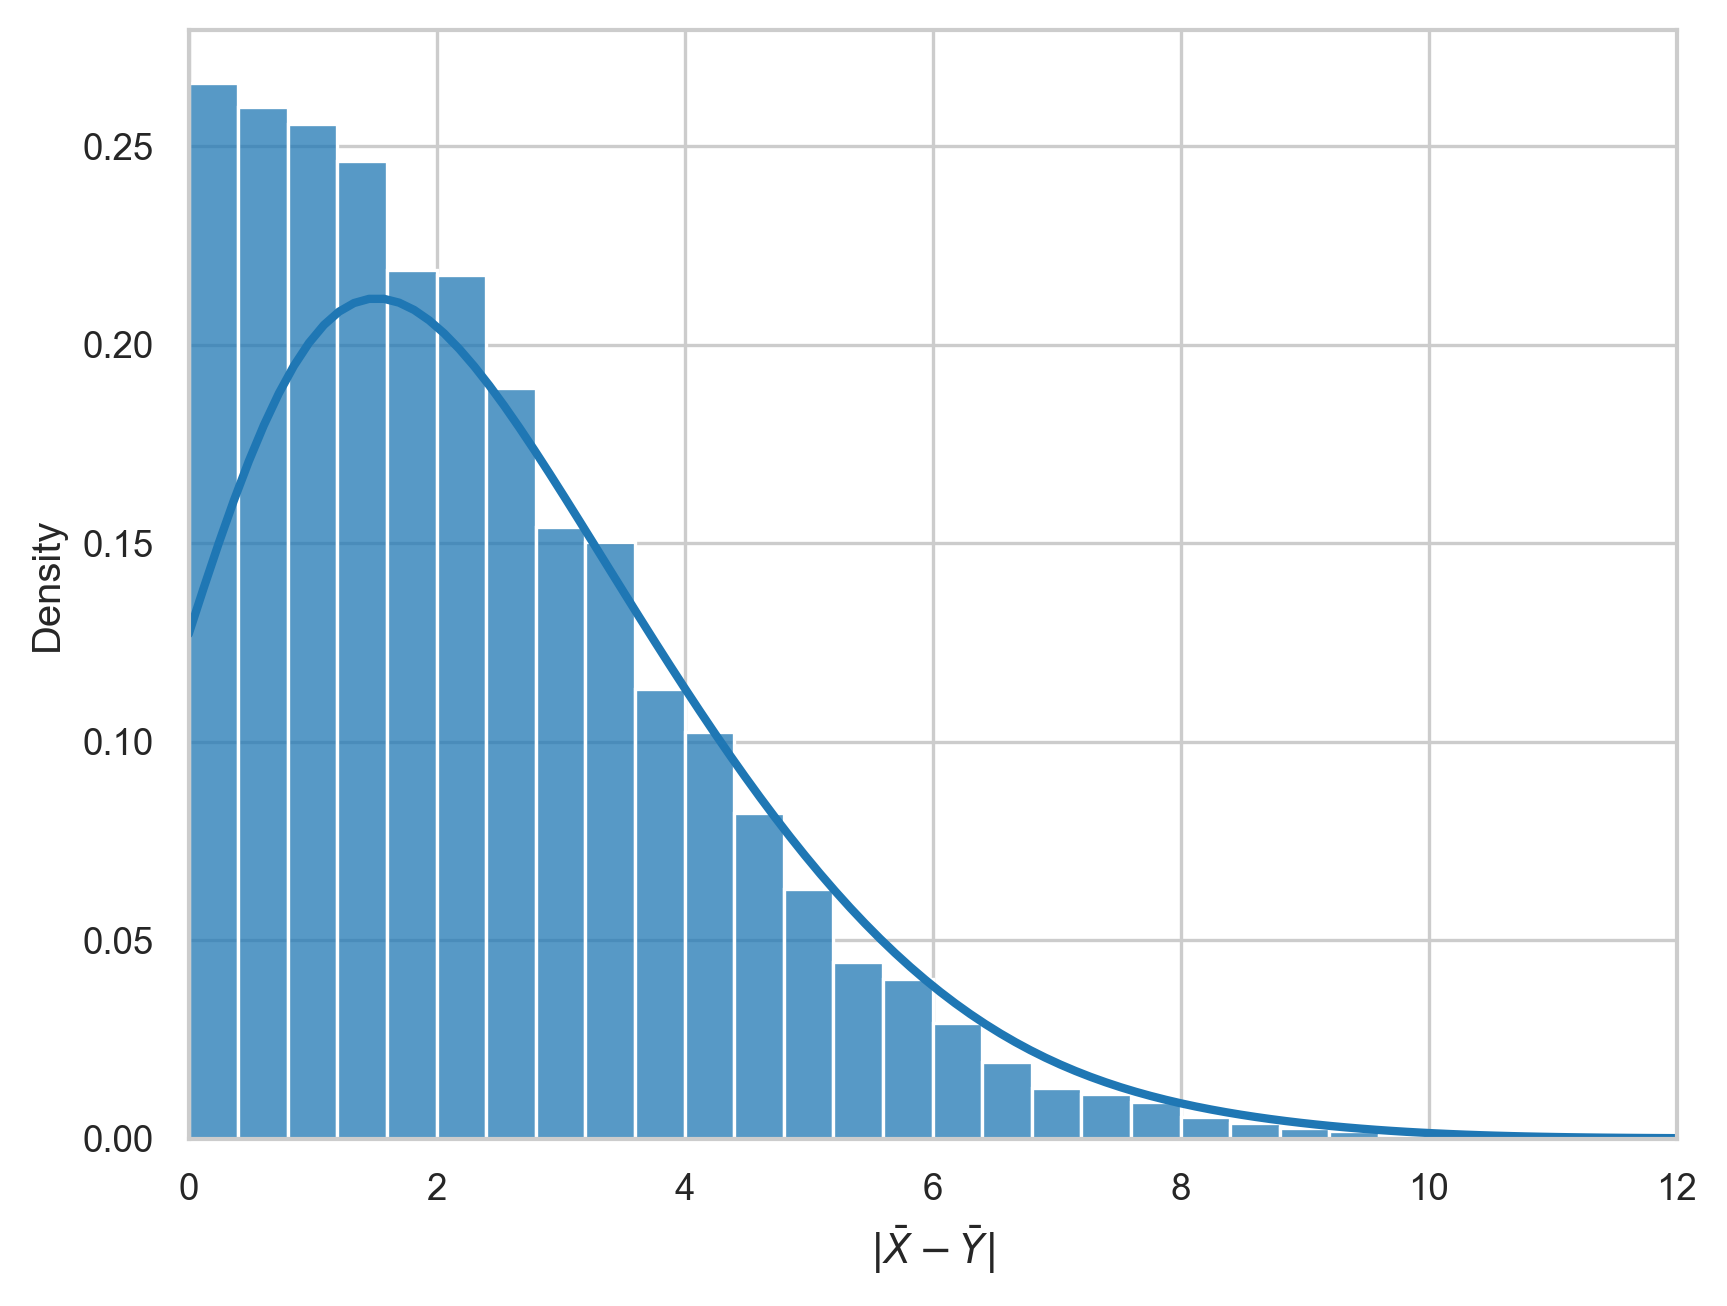

In [12]:
obs = result['observations']
edf = result['edf']
plot_x = np.linspace(0, 12, 100)
plot_y = edf.pdf(plot_x)
edf_hist = sns.histplot(x=obs, stat='density', binwidth=.4, binrange=(0,12))
sns.lineplot(x=plot_x, y=plot_y, ax=edf_hist, lw=2)
edf_hist.set_xlabel(r'$|\bar{X} - \bar{Y}|$')
edf_hist.set_xlim(0, 12)
plt.show()

In [13]:
# Annotating manhattan plot using results from random forest feature importance analysis
annotations = pd.read_csv('./data/gene_annotations.csv')
annotations

,Chr,start,end,SNP location,gene name
0,1,3841286,3844432,3841346,AT1G11410
1,1,3841286,3844432,3844044,AT1G11410
2,1,3871778,3872836,3872522,AT1G11510
3,1,3871778,3872836,3872387,AT1G11510
4,1,3873029,3873619,3873444,AT1G11520
5,1,3874437,3875484,3874595,AT1G11530
6,1,3874437,3875484,3874948,AT1G11530
7,1,3878550,3880361,3880217,AT1G11545
8,1,3976839,3979195,3978064,AT1G11780
9,2,8858988,8864865,8862404,AT2G20580


In [14]:
# Adjust starting and ending position of gene annotations in a similar way to the SNP locations in the test results
annotations.loc[:,'adjusted_start'] = annotations.loc[:,'start']
annotations.loc[:,'adjusted_end'] = annotations.loc[:,'end']
for i in range(1,5):
    annotations.loc[annotations['Chr'] == i+1, 'adjusted_start'] = annotations.loc[annotations['Chr'] == i+1, 'start'].copy() + start_positions[i-1]
    annotations.loc[annotations['Chr'] == i+1, 'adjusted_end'] = annotations.loc[annotations['Chr'] == i+1, 'end'].copy() + start_positions[i-1]

In [15]:
annot_1 = annotations.loc[:8].copy()
annot_2 = annotations.loc[9:10].copy()
annot_3 = annotations.loc[11:12].copy()
annot_4 = annotations.loc[13,:].copy()

In [46]:
def plot_annotations(ax: plt.Axes, subset, pval_col = 'negative_log_p'):
    xmin = subset['adjusted_start'].min() - 1000000
    xmax =  subset['adjusted_end'].max() + 1000000
    if isinstance(subset, pd.DataFrame):
        subset = subset.reset_index()
        chr = subset.loc[0,'Chr']
        genes = list(subset['gene name'].unique())
        label = ', '.join([f'\n{g}' if (i % 3 == 0) else f'{g}' for i, g in enumerate(genes)])
    else:
        chr = subset['Chr']
        label = f'\n{subset['gene name']}'
    y = test_results.loc[(test_results['chromosome'] == chr) & (test_results['adjusted_position'] > xmin) & (test_results['adjusted_position'] < xmax) , pval_col].max()+.3
    rect_col = sns.desaturate(palette[chr-1],.4)
    ax.add_patch(Rectangle(xy=(xmin,0), width=xmax-xmin, height=y, fill=False, color = rect_col, lw=1.5))
    x_midpoint = (test_results['adjusted_position'].max() + test_results['adjusted_position'].min())/2
    if xmax < x_midpoint:
        ax.text(x=xmax + 500000, y=y+.5, s=label, size='xx-small', ha='left', va='top', c=rect_col, fontweight='semibold')
    else:
        ax.text(x= xmin - 500000, y=y+.5, s=label, size='xx-small', ha='right', va='top', c=rect_col, fontweight='semibold')

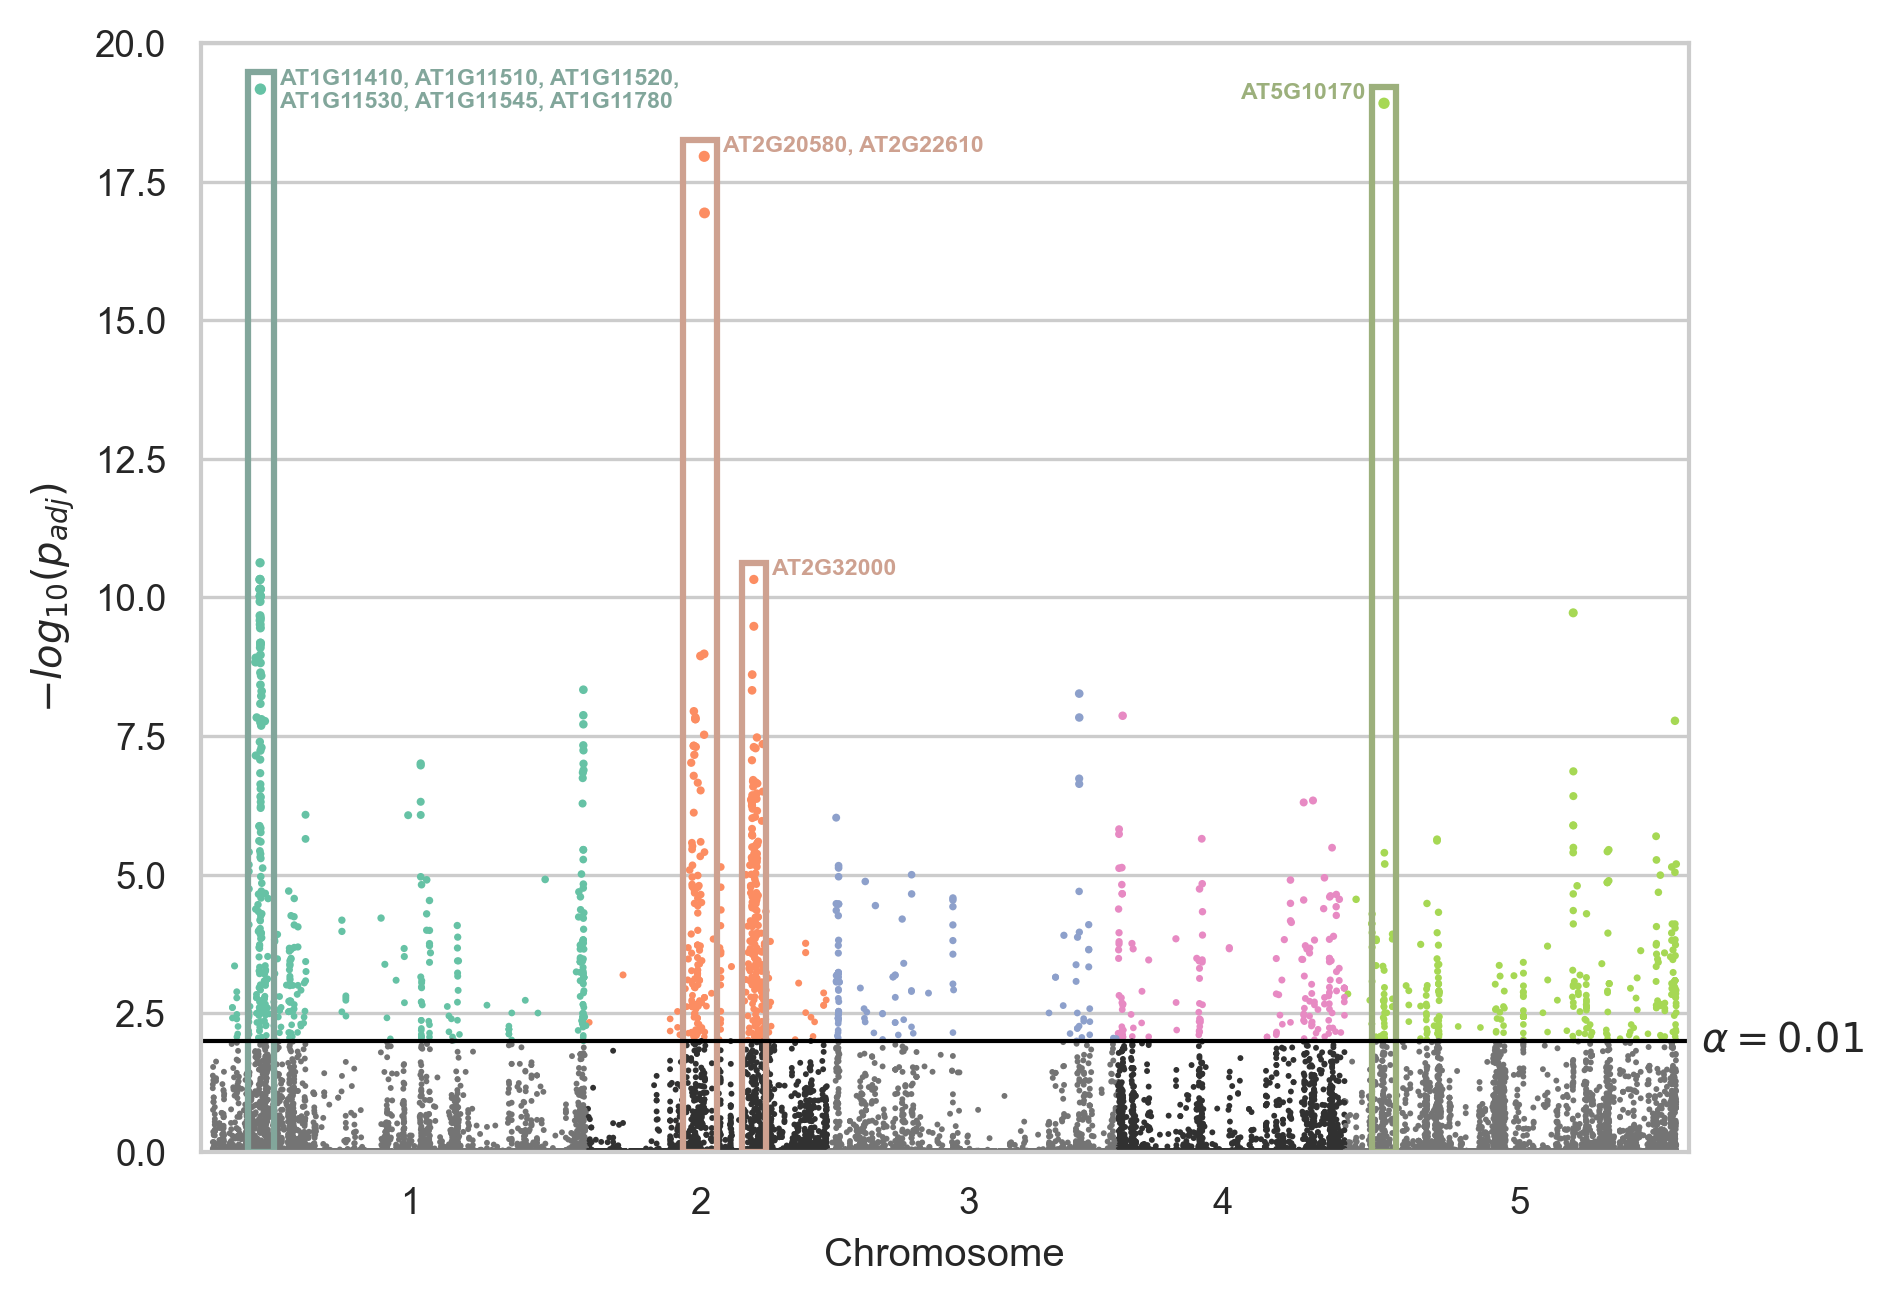

In [17]:
test_results = pd.read_csv('./data/stat_test_results.csv')
test_results['negative_log_p'] = -1 * np.log10(test_results['corrected_pval'])
test_results['chromosome'] = test_results['location'].map(lambda x: int(str.split(x, ':')[0]))
test_results['position'] = test_results['location'].map(lambda x: int(str.split(x, ':')[1]))
test_results['adjusted_position'] = test_results['position']

start_positions = np.cumsum([test_results.loc[test_results['chromosome'] == i, 'position'].max() for i in range(1,6)])
for i in range(1,5):
    test_results.loc[test_results['chromosome'] == i+1, 'adjusted_position'] = test_results.loc[test_results['chromosome'] == i+1, 'position'] + start_positions[i-1]

fig,ax = plt.subplots()
sns.scatterplot(data=test_results[test_results['negative_log_p'] > thresh], x='adjusted_position', y='negative_log_p', 
                            hue='chromosome', marker='.', linewidth=0, size='negative_log_p', sizes=(10,30), palette=palette,legend=False, ax=ax)
sns.scatterplot(data=test_results[test_results['negative_log_p'] <= thresh], x='adjusted_position', y='negative_log_p',
                 marker='.', linewidth=0, s=8, hue='chromosome', palette=gray_pallette, ax=ax, legend=False)
plot_annotations(ax, annot_1)
plot_annotations(ax, annot_2)
plot_annotations(ax, annot_3)
plot_annotations(ax, annot_4)
ax.set_xticks(medians, labels=[str(x) for x in chromosomes])
ax.set_ylim(0, 20)
ax.set_xlabel('Chromosome')
ax.set_ylabel(r'$-log_{10}(p_{adj})$')
ax.set_xlim(test_results['adjusted_position'].min()-1000000, test_results['adjusted_position'].max() + 1000000)
ax.axhline(y=thresh, c='black', lw=1)
ax.text(x=ax.get_xlim()[1]+1000000, y=thresh, s=r'$\alpha=0.01$', ha='left', va='center')
ax.grid(axis='x', visible=False)
plt.show()

In [39]:
# Repeat using permutation test results
perm_annotations = pd.read_csv('./data/perm_test_gene_annotations.csv')
perm_annotations.loc[:,'adjusted_start'] = perm_annotations.loc[:,'start']
perm_annotations.loc[:,'adjusted_end'] = perm_annotations.loc[:,'end']
for i in range(1,5):
    perm_annotations.loc[perm_annotations['Chr'] == i+1, 'adjusted_start'] = perm_annotations.loc[perm_annotations['Chr'] == i+1, 'start'].copy() + start_positions[i-1]
    perm_annotations.loc[perm_annotations['Chr'] == i+1, 'adjusted_end'] = perm_annotations.loc[perm_annotations['Chr'] == i+1, 'end'].copy() + start_positions[i-1]

In [41]:
perm_annot_1 = perm_annotations.loc[:6].copy()
perm_annot_2 = perm_annotations.loc[7,:].copy()
perm_annot_3 = perm_annotations.loc[8:9].copy()
perm_annot_4 = perm_annotations.loc[10,:].copy()
perm_annot_5 = perm_annotations.loc[11,:].copy()
perm_annot_6 = perm_annotations.loc[12,:].copy()
perm_annot_7 = perm_annotations.loc[13,:].copy()

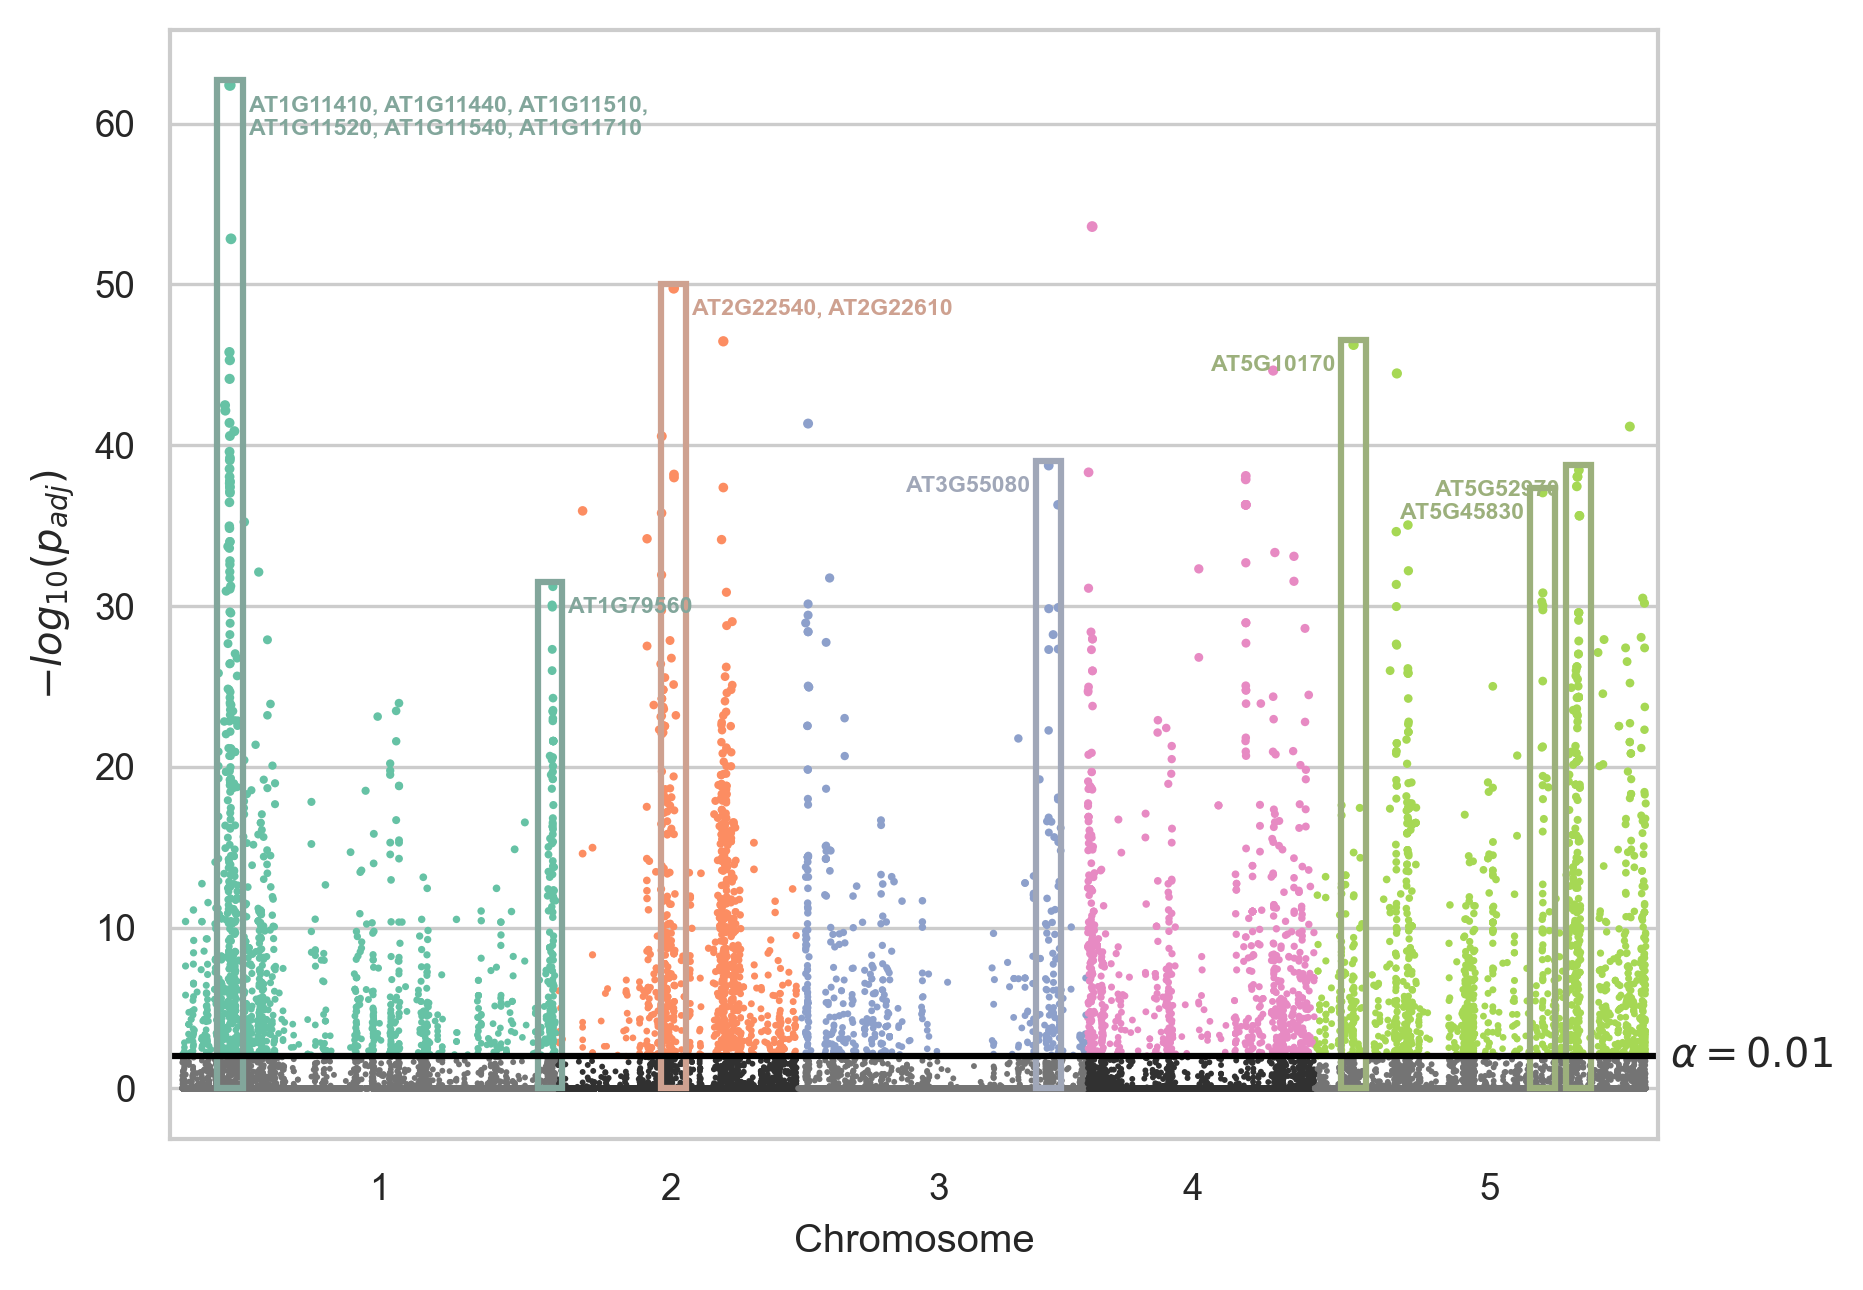

In [51]:
perm_manhattan = sns.scatterplot(data=test_results[test_results['perm_negative_log_p'] > thresh], x='adjusted_position', y='perm_negative_log_p', 
                            hue='chromosome', marker='.', linewidth=0, size='perm_negative_log_p', sizes=(10,30), palette=palette,legend=False)
sns.scatterplot(data=test_results[test_results['perm_negative_log_p'] <= thresh], x='adjusted_position', y='perm_negative_log_p',
                 marker='.', linewidth=0, s=8, hue='chromosome', palette=gray_pallette, ax=perm_manhattan, legend=False)
plot_annotations(perm_manhattan, perm_annot_1, 'perm_negative_log_p')
plot_annotations(perm_manhattan, perm_annot_2, 'perm_negative_log_p')
plot_annotations(perm_manhattan, perm_annot_3, 'perm_negative_log_p')
plot_annotations(perm_manhattan, perm_annot_4, 'perm_negative_log_p')
plot_annotations(perm_manhattan, perm_annot_5, 'perm_negative_log_p')
plot_annotations(perm_manhattan, perm_annot_6, 'perm_negative_log_p')
plot_annotations(perm_manhattan, perm_annot_7, 'perm_negative_log_p')
perm_manhattan.set_xticks(medians, labels=[str(x) for x in chromosomes])
perm_manhattan.set_xlabel('Chromosome')
perm_manhattan.set_ylabel(r'$-log_{10}(p_{adj})$')
perm_manhattan.set_xlim(test_results['adjusted_position'].min()-1000000, test_results['adjusted_position'].max() + 1000000)
perm_manhattan.axhline(y=thresh, c='black', lw=1.5)
perm_manhattan.grid(axis='x', visible=False)
perm_manhattan.text(x=perm_manhattan.get_xlim()[1]+1000000, y=thresh, s=r'$\alpha=0.01$', ha='left', va='center')
plt.show()

In [18]:
# Create 'volcano plot' Showing difference in flowering time for 'wild type' (majority identity at SNP) versus wild type
genotype = pd.read_csv('./data/processed.csv', index_col=0, header=None).transpose().astype({'5_FT10':np.float64})
# Get only SNPs that show up in test results
genotype = genotype[['5_FT10'] + test_results['location'].to_list()]

In [19]:
volc_size = [None for i in range(len(genotype.columns.to_list()[1:]))]
volcano_data = pd.DataFrame({'location':volc_size, 'wt_base':volc_size, 'mut_base':volc_size, 'wt_mean_ft':volc_size, 'mut_mean_ft':volc_size, 'n_wt':volc_size, 'n_mut':volc_size})
for i, location in enumerate(genotype.columns.to_list()[1:]):
    snp = genotype[location]
    counts = snp.value_counts().sort_values(ascending=False)
    wt_mean = genotype.loc[genotype[location] == counts.index[0], '5_FT10'].mean()
    mut_mean = genotype.loc[genotype[location] == counts.index[1], '5_FT10'].mean()
    volcano_data.loc[i,:] = {'location':location, 'wt_base':counts.index[0], 'mut_base':counts.index[1], 'wt_mean_ft':wt_mean, 'mut_mean_ft':mut_mean, 'n_wt':counts.iloc[0], 'n_mut':counts.iloc[1]}
    # volcano_data = pd.concat([volcano_data, new_row])

In [20]:
volcano_data['diff'] = volcano_data['mut_mean_ft'] - volcano_data['wt_mean_ft']
test_results_volcano = pd.read_csv('./data/stat_test_results.csv', usecols=['location', 'corrected_pval'])
volcano_data_merged = pd.merge(test_results, volcano_data, on='location')

In [21]:
volcano_data_merged['logp'] = -np.log10(volcano_data_merged['corrected_pval'])
volcano_data_merged = volcano_data_merged.loc[volcano_data_merged['logp'] > 0]
volcano_data_merged

,location,A_mean,T_mean,C_mean,G_mean,pval,corrected_pval,perm_pval,perm_corrected_pval,negative_log_p,...,position,adjusted_position,wt_base,mut_base,wt_mean_ft,mut_mean_ft,n_wt,n_mut,diff,logp
0,1:3877554,68.001282,NaN,NaN,96.230921,6.807010e-20,6.807010e-20,1.889663e-68,1.889663e-68,1.916704e+01,...,3877554,3877554,G,A,96.230921,68.001282,152,78,-28.229639,1.916704e+01
1,5:3188327,NaN,99.853211,74.770248,NaN,1.225052e-19,1.225052e-19,2.670134e-52,2.670134e-52,1.891185e+01,...,3188327,95343378,C,T,74.770248,99.853211,121,109,25.082963,1.891185e+01
2,2:9581605,NaN,NaN,97.063043,71.048913,1.109792e-18,1.109792e-18,8.201731e-56,8.201731e-56,1.795476e+01,...,9581605,40006666,C,G,97.063043,71.048913,138,92,-26.01413,1.795476e+01
3,2:9604507,71.712903,NaN,96.802190,NaN,1.164072e-17,1.164072e-17,4.768051e-44,4.768051e-44,1.693402e+01,...,9604507,40029568,C,A,96.80219,71.712903,137,93,-25.089287,1.693402e+01
4,1:3849924,97.322137,72.545455,NaN,NaN,1.400263e-16,2.378264e-11,1.376967e-44,1.376967e-44,1.062374e+01,...,3849924,3849924,A,T,97.322137,72.545455,131,99,-24.776683,1.062374e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15809,5:10895092,NaN,NaN,73.867647,88.876020,1.827502e-04,1.000000e+00,6.350764e-05,9.999970e-01,9.643275e-17,...,10895092,103050143,G,C,88.87602,73.867647,196,34,-15.008373,9.643275e-17
15810,3:6693226,84.808911,99.992857,NaN,NaN,1.827559e-04,1.000000e+00,6.035088e-04,1.000000e+00,9.643275e-17,...,6693226,56813087,A,T,84.808911,99.992857,202,28,15.183946,9.643275e-17
15811,1:11686168,NaN,NaN,88.240094,68.016667,1.827723e-04,1.000000e+00,2.057911e-04,1.000000e+00,9.643275e-17,...,11686168,11686168,C,G,88.240094,68.016667,212,18,-20.223428,9.643275e-17
15812,5:21838386,NaN,74.231250,88.665657,NaN,1.829726e-04,1.000000e+00,5.416845e-04,1.000000e+00,9.643275e-17,...,21838386,113993437,C,T,88.665657,74.23125,198,32,-14.434407,9.643275e-17


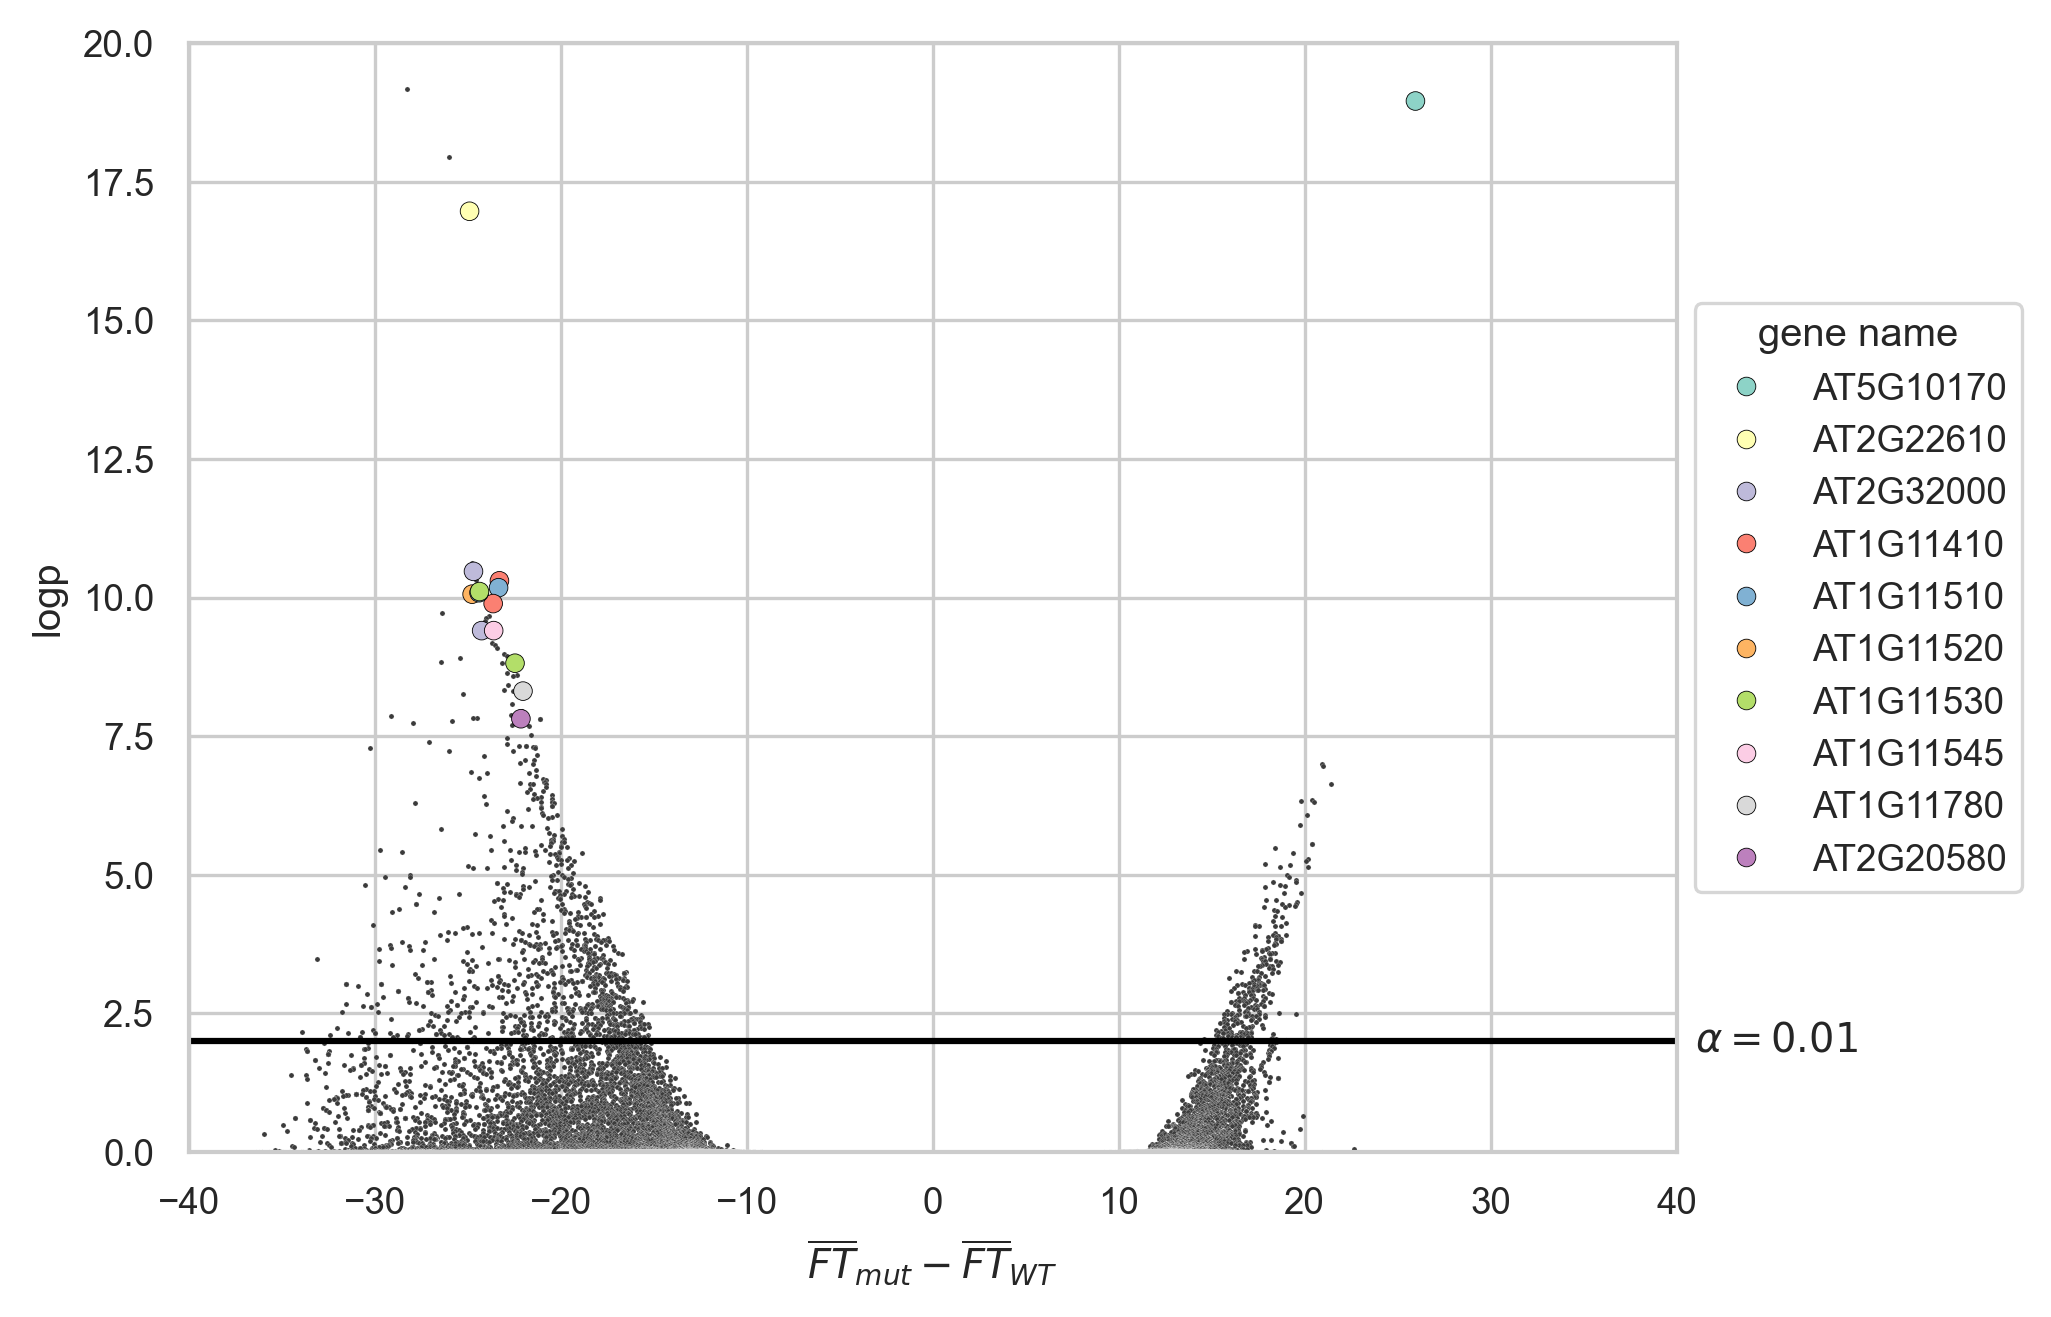

In [37]:
# "#747474", "#313131"
annot_locs = [':'.join(x) for x in annotations[['Chr', 'SNP location']].to_numpy().astype(str)]
annotations['location'] = annot_locs
annot_data = pd.merge(volcano_data_merged.loc[volcano_data_merged['location'].isin(annot_locs)], annotations[['location', 'gene name']], on='location')
np.random.seed(0)
annot_data['diff_jitter'] = annot_data['diff'] + np.random.normal(0,.5, len(annot_data))
annot_data['logp_jitter'] = annot_data['logp'] + np.random.normal(0,.1, len(annot_data))
volcano_plot = sns.scatterplot(volcano_data_merged.loc[(~volcano_data_merged['location'].isin(annot_locs)),:], 
                               x='diff', y='logp', 
                               c="#3B3B3B", lw=.05, legend=False, s=1.5, edgecolor='white')

sns.scatterplot(annot_data, x='diff_jitter', y='logp_jitter', hue='gene name', palette=sns.color_palette('Set3', 10), edgecolor='black', s=20, lw=.2)

volcano_plot.set_xlabel(r'$\overline{FT}_{mut}-\overline{FT}_{WT}$')
volcano_plot.set_xlim((-40,40))
volcano_plot.set_ylim((0,20))
volcano_plot.axhline(y=thresh, c='black', lw=1.5)
volcano_plot.text(x=volcano_plot.get_xlim()[1] + 1, y=thresh, s=r'$\alpha=0.01$', ha='left', va='center')
volcano_plot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='gene name') 

plt.show()

In [32]:
annot_data[['location', 'gene name', 'wt_base', 'mut_base', 'wt_mean_ft', 'mut_mean_ft', 'diff', 'corrected_pval']]

,location,gene name,wt_base,mut_base,wt_mean_ft,mut_mean_ft,diff,corrected_pval
0,5:3188327,AT5G10170,C,T,74.770248,99.853211,25.082963,1.225052e-19
1,2:9604507,AT2G22610,C,A,96.80219,71.712903,-25.089287,1.164072e-17
2,2:13618247,AT2G32000,A,G,95.411333,70.24375,-25.167583,4.756506e-11
3,1:3844044,AT1G11410,T,G,97.373643,72.970297,-24.403346,4.756506e-11
4,1:3872387,AT1G11510,G,A,97.522835,73.260194,-24.26264,7.134660e-11
5,1:3873444,AT1G11520,A,G,97.522835,73.260194,-24.26264,7.134660e-11
6,1:3841346,AT1G11410,G,T,97.448031,73.352427,-24.095604,7.134660e-11
7,1:3872522,AT1G11510,G,T,97.435156,73.132353,-24.302803,9.512702e-11
8,1:3874948,AT1G11530,G,A,97.435156,73.132353,-24.302803,9.512702e-11
9,2:13619418,AT2G32000,A,C,95.266443,70.820988,-24.445455,3.329290e-10
